# P9 - Réalisez une application de recommandation de contenu

### Installation des librairies

    # !pip install tensorflow==2.9.1
    # !pip install keras==2.9.0
    !pip install pandas
    !pip install numpy
    !pip install ipywidgets!pip install ipywidgets
    !pip install pickle # not install
    #!pip install sklearn
    #!pip install sentencepiece
    #!pip install missingno
    #!pip install shap
    #!pip install tqdm
    #!pip install opencv-python
    #!pip install keras-segmentation
    !pip install pycodestyle
    !pip install flake8
    !pip install pycodestyle_magic
    !pip install nb_black
    #!pip install tensorflow_addons
    !pip install --upgrade pip
    !pip install scikit-learn
    !pip install seaborn
    !pip install scikit-surprise


### Import des libairies 

In [63]:
# METTRE A JOUR 
# from src.libraries import *
# from src.data_helpers import *
# from src.classes import *

# warnings.filterwarnings("ignore")

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import glob
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

### Import des fonctions

In [65]:
def select_article(option, clicks, user_id):
    # Reduce dataset to user_id user
    clicks_red = clicks[clicks['user_id']==user_id]
    if len(clicks_red['click_article_id'].to_list())==0:
           return print("Zero article read. Random article recommendation")
    else:       
        if option == 'last':
            print('Last read article')

            # Get index of last click
            idx = clicks_red['click_time'].idxmax()
            print(f"Click index : {idx}")
            print(f"Click date : {clicks_red['click_time'][idx].strftime('%Y-%m-%d %H:%M:%S')}")
            # print(clicks_red) # Check sanity

            # Get article
            article_id = clicks_red['click_article_id'][idx]

            print(f"Most recent article id : {article_id}")

        elif option == 'most clicked':
            print('Most clicked article')

            # Get index of most clicked article
            articles_red = clicks_red.groupby('click_article_id').agg({
                'user_id':'count','click_time':'last',
                })
            articles_red = articles_red.rename(columns={'user_id':'total clics','click_time':'last click'})
            #print(articles_red) # Check sanity
            #print(clicks_red) # Check sanity

            # Get article
            article_id = articles_red.loc[articles_red['total clics']==articles_red['total clics'].max()]['last click'].idxmax()
            print(f"Number of clicks : {articles_red['total clics'][article_id]}")
            print(f"Article id: {article_id}")
             
    return article_id #clicks_red[clicks_red['click_article_id']==article_id]

def get_cosinsimilarity(df_articles_embeddings,article_id):
    # Get embedding vector for article_id
    embedding = df_articles_embeddings.loc[article_id] 
    
    # Remove embedding vector from embedding matrix
    df_articles_embeddings = df_articles_embeddings.drop(article_id)

    # Compute cosin similarity
    cosine_similarities = cosine_similarity([embedding], df_articles_embeddings)
    
    # Get indices of 5 most similar articles (sorted)
    indices = np.argsort(cosine_similarities[0])[::-1][:5]
    
    # Get corresponding article IDs
    recos = list(df_articles_embeddings.iloc[indices].index)
    return recos

# Histogramme de la distribution d'une variable'
def visualize_histogram(hist_var, hist_title, hist_x_label, hist_fig): 
    # Calcul des quartiles Q1, Q2 (médiane), Q3
    q1, q2, q3 = hist_var.quantile([0.25, 0.5, 0.75])

    # Calcul des limites des whiskers
    iqr = q3 - q1  # plage interquartile
    whisker_min = q1 - 1.5 * iqr
    whisker_max = q3 + 1.5 * iqr

    # Création du boxplot avec les limites de whisker et les quartiles
    fig = plt.figure(figsize=figsize)
    
    bp = plt.boxplot(hist_var, vert=False, widths=0.5, positions=[0], whis=[1,99])
    plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
    plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)
    
    plt.hlines(y=1, xmin=whisker_min, xmax=q1, colors='b', lw=2)
    plt.hlines(y=1, xmin=q3, xmax=whisker_max, colors='b', lw=2)
    plt.hlines(y=1, xmin=q1, xmax=q3, colors='r', lw=2)
    
    plt.title(hist_title)
    plt.xlabel(hist_x_label)
    plt.yticks([1], ["Valeurs typiques"])
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    #plt.xscale('log')

    plt.show()
    fig.savefig(hist_fig, dpi=300, bbox_inches='tight')


### Mise en forme convention PEP8

In [66]:
# METTRE A JOUR 
# Mise en forme convention PEP8
#%load_ext nb_black
#%load_ext pycodestyle_magic
#%pycodestyle_on

### Paramètres généraux

In [67]:
figsize = (8,6) # figure size
random_state = 18 # random state

## 1. Contexte

La startup My Content souhaite encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs. 

En tant que CTO de cette société, il est demandé de construire un MVP sous la forme d'une application.
- La fonctionnalité principale de cette application est la **recommandation de 5 articles par utilisateur**.
- Une contrainte critique à prendre en compte dans la conception du MVP est l'**ajout ultérieur de nouveaux utilisateurs ou articles dans l'architecture choisie**.

Après discussion avec l'équipe de développement, deux architectures serverless sont envisagées :
- Utilisation d'une Azure Fonction
    - création d’API pour développer et exposer le système de recommandations
    - création d’une Azure fonction pour lier système de recommandations et API
- Azure Blob Storage Input Binding (sans API)
    - Récupération directe des fichiers et modèles
    - Intégration des prédictions dans Azure Fonctions
    
La startup ne possédant pas encore de données, un jeu de données existant est utilisé pour la conception de l'API. 

## 2. Jeu de données

Le jeu de données issu de Kaggle contient 4 éléments
- Un fichier intitulé **articles_metadata.csv** contenant des informations générales sur les articles; 
- un fichier **clicks_sample.csv** contenant des informations sur chaque clic; 
- un dossier clicks contenant 85 fichiers clicks_hour_X.csv**, similaires au fichier clicks_sample;
- un fichier **articles_embeddings.pickle** contenant des embeddings d'articles.

Ce jeu doit nous permettre de fournir les interactions des utilisateurs avec les articles disponibles, notamment :
- des informations sur les articles (par exemple nombre de mots); 
- des informations sur les sessions d’utilisateur (par exemple heures de début et de fin);
- les interactions des utilisateurs avec les articles (sur quels articles l'utilisateur a cliqué lors de sa session).

### 2.1 Articles

Le dataset **articles_metadata** est une liste de 364047 articles avec, pour chacun, les informations suivantes :
- **article_id** : id de l'article
- **category_id**: catégorie de l'article
- **created_at_ts**: ancienneté de l'article
- **publisher_id**: id de l'éditeur (information identique partout)
- **words_count**: nombre de mots par article

In [68]:
# Upload articles_metadata file
articles_metadata = pd.read_csv('data/articles_metadata.csv')

print("Forme du dataset : " + str(articles_metadata.shape))
print("Features : " + str(articles_metadata.keys().tolist()))

articles_metadata['creation date'] = pd.to_datetime(articles_metadata['created_at_ts'], unit='ms').dt.date

Forme du dataset : (364047, 5)
Features : ['article_id', 'category_id', 'created_at_ts', 'publisher_id', 'words_count']


<u> Visualisation du dataset et de quelques données statistiques <u>

In [69]:
articles_metadata.head(3)

,article_id,category_id,created_at_ts,publisher_id,words_count,creation date
0,0,0,1513144419000,0,168,2017-12-13
1,1,1,1405341936000,0,189,2014-07-14
2,2,1,1408667706000,0,250,2014-08-22


In [70]:
articles_metadata.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


Il existe 461 catégories d'articles distribués de façon non homogène :

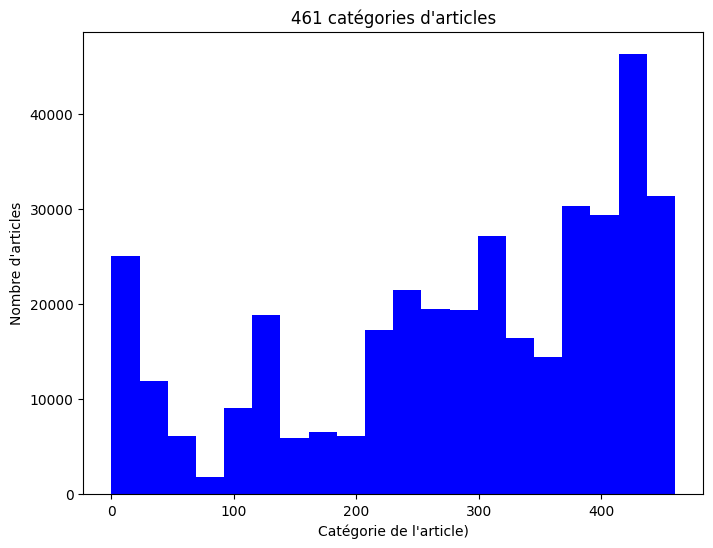

In [71]:
# Histogramme des catégories d'articles
fig = plt.figure(figsize=figsize)

plt.hist(articles_metadata["category_id"], bins=20, color='blue')
plt.xlabel("Catégorie de l'article)")
plt.ylabel("Nombre d'articles")
plt.title(f"{len(articles_metadata['category_id'].value_counts())} catégories d'articles")

# Utiliser une échelle logarithmique sur l'axe y
# plt.yscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 1.E6])

plt.show()
fig.savefig('data/figs/categories.png', dpi=300, bbox_inches='tight')

Le nombre de mots par article est en moyenne de 190, avec beaucoup de valeurs atypiques :

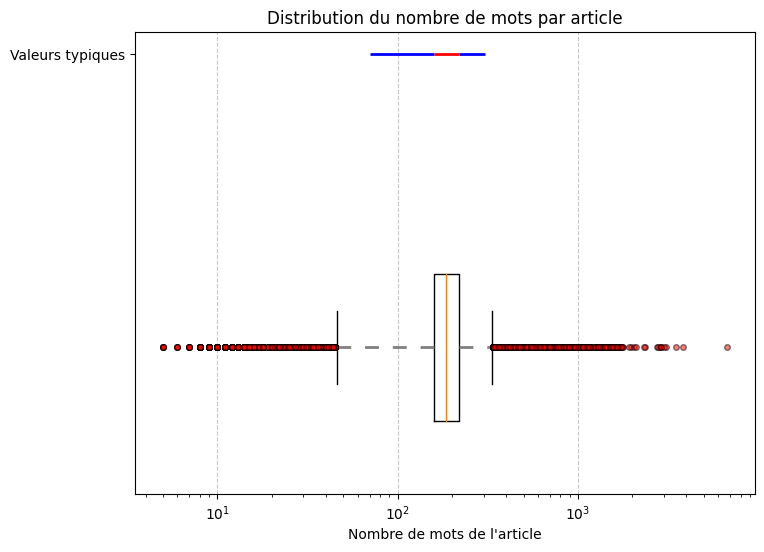

In [72]:
# Calcul des quartiles Q1, Q2 (médiane), Q3
q1, q2, q3 = articles_metadata["words_count"].quantile([0.25, 0.5, 0.75])

# Calcul des limites des whiskers
iqr = q3 - q1  # plage interquartile
whisker_min = q1 - 1.5 * iqr
whisker_max = q3 + 1.5 * iqr

# Création du boxplot avec les limites de whisker et les quartiles
fig = plt.figure(figsize=figsize)
bp = plt.boxplot(articles_metadata["words_count"], vert=False, widths=0.5, positions=[0], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)
plt.hlines(y=1, xmin=whisker_min, xmax=q1, colors='b', lw=2)
plt.hlines(y=1, xmin=q3, xmax=whisker_max, colors='b', lw=2)
plt.hlines(y=1, xmin=q1, xmax=q3, colors='r', lw=2)
plt.title("Distribution du nombre de mots par article")
plt.xlabel("Nombre de mots de l'article")
plt.yticks([1], ["Valeurs typiques"])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xscale('log')

plt.show()
fig.savefig('data/figs/wordcount.png', dpi=300, bbox_inches='tight')

Les articles sont datés de 2012 à 2018 :

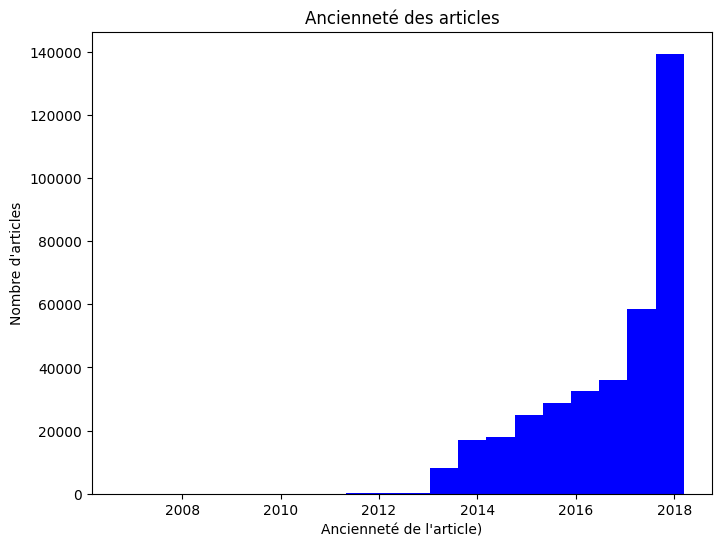

In [73]:
# Histogramme de l'ancienneté des articles
fig = plt.figure(figsize=figsize)
plt.hist(articles_metadata["creation date"], bins=20, color='blue')
plt.xlabel("Ancienneté de l'article)")
plt.ylabel("Nombre d'articles")
plt.title("Ancienneté des articles")

# Utiliser une échelle logarithmique sur l'axe y
# plt.yscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 1.E6])

plt.show()
fig.savefig('data/figs/article_creationdate.png', dpi=300, bbox_inches='tight')

Ainsi, nous conservons dans ce datast, pour chaque que article :
- Son id
- Son ancienneté 
- Sa catégorie
- Son nombre de mots

### 2.2 Clics

#### 2.2.1 Echantillon clicks_sample

Le dataset **clicks_sample** permet d'illustrer le contenu de chacun des fichiers click_hours.
Il contient 1883 éléments avec, pour chacun :
- des informations sur l'utilisateur :user_id,
- des informations sur la session en cours : session_id,session_start,session_size,
- des informations sur le clic : click_article_id, click_timestamp,click_environment,click_deviceGroup,click_os, click_country,click_region,click_referrer_type

In [74]:
# Upload .csv file
clicks_sample = pd.read_csv('data/clicks_sample.csv')

print("Forme du dataset : " + str(clicks_sample.shape))
print("-")
print("Features : " + str(clicks_sample.keys().tolist()))
print("-")
print("Types de fichiers : ")
clicks_sample.dtypes

Forme du dataset : (1883, 12)
-
Features : ['user_id', 'session_id', 'session_start', 'session_size', 'click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']
-
Types de fichiers : 


user_id                int64
session_id             int64
session_start          int64
session_size           int64
click_article_id       int64
click_timestamp        int64
click_environment      int64
click_deviceGroup      int64
click_os               int64
click_country          int64
click_region           int64
click_referrer_type    int64
dtype: object

<u> Informations concernant l'échantillon clicks_sample </u>

In [75]:
print("Informations concernant l'échantillon clicks_sample : ")
print(f"- {len(clicks_sample)} clics")
print(f"- {len(clicks_sample['user_id'].value_counts())} utilisateurs")
print(f"- {len(clicks_sample['session_id'].unique())} sessions")
print(f"- Plusieurs sessions commencent en même temps ({len(clicks_sample['session_start'].unique())} valeurs uniques de début de session)")
print(f"- {len(clicks_sample['session_size'].unique())} tailles uniques de session : {clicks_sample['session_size'].unique().tolist()}")
print(f"- {len(clicks_sample['click_article_id'].unique())} articles différents consultés")
print(f"- click_timestamp renseigne sur la date de clic ({len(clicks_sample['click_timestamp'].unique()) } valeurs uniques)")
print(f"- {len(clicks_sample['click_environment'].unique())} valeurs d'environnement : {clicks_sample['click_environment'].unique().tolist()}")
print(f"- Similaire pour click_deviceGroup, click_os, click_country (7), click_region (26), click_referrer_type (6)")

Informations concernant l'échantillon clicks_sample : 
- 1883 clics
- 707 utilisateurs
- 707 sessions
- Plusieurs sessions commencent en même temps (619 valeurs uniques de début de session)
- 11 tailles uniques de session : [2, 3, 7, 6, 4, 5, 16, 8, 10, 9, 24]
- 323 articles différents consultés
- click_timestamp renseigne sur la date de clic (1883 valeurs uniques)
- 3 valeurs d'environnement : [4, 2, 1]
- Similaire pour click_deviceGroup, click_os, click_country (7), click_region (26), click_referrer_type (6)


In [76]:
# Check  for different variables if all the data is the same per user 
for idx in clicks_sample['user_id']:
    if len(clicks_sample[clicks_sample['user_id']==idx]['session_size'].unique())!=1:
       print(idx)
# Exceptions (minor) 
# - User 327 : region is changing
# - User 231,648 : environment is changing
# - Session size is not changing : it's the number of articles/clics per session/user

Toutes les informations ne sont pas utiles pour notre étude. 
Certaines sont redondantes et donc supprimées du dataset.


Ainsi, les informations pertinentes au regard de notre problématique sont :
- user_id
- session_size : nombre de clics/d'articles lus par l'utilisateur
- click_article_id 
- click_timestamp : date de clic associé à un article (ajoutée en date abolue)

<u> Visualisation du dataset et de quelques données statistiques <u>

In [77]:
clicks_sample['click_time'] = pd.to_datetime(clicks_sample['click_timestamp'], unit='ms')#.dt#.date

In [78]:
clicks_sample = clicks_sample.drop(
        columns=['session_start','session_id',
                 'click_environment','click_os','click_referrer_type',
                 'click_deviceGroup','click_region','click_country'])

In [79]:
clicks_sample.head(5)

,user_id,session_size,click_article_id,click_timestamp,click_time
0,0,2,157541,1506826828020,2017-10-01 03:00:28.020
1,0,2,68866,1506826858020,2017-10-01 03:00:58.020
2,1,2,235840,1506827017951,2017-10-01 03:03:37.951
3,1,2,96663,1506827047951,2017-10-01 03:04:07.951
4,2,2,119592,1506827090575,2017-10-01 03:04:50.575


In [80]:
clicks_sample.describe()

,user_id,session_size,click_article_id,click_timestamp
count,1883.000000,1883.000000,1883.000000,1.883000e+03
mean,355.893787,3.459904,176717.848646,1.506830e+12
std,206.162865,3.037467,82324.177259,1.064938e+07
min,0.000000,2.000000,2137.000000,1.506827e+12
25%,181.500000,2.000000,108854.000000,1.506828e+12
50%,353.000000,3.000000,157541.000000,1.506828e+12
75%,537.000000,4.000000,236697.500000,1.506829e+12
max,706.000000,24.000000,363291.000000,1.506998e+12


Le nombre d'articles par utilisateur varie de 2 à 24 et est inégalement distribué :

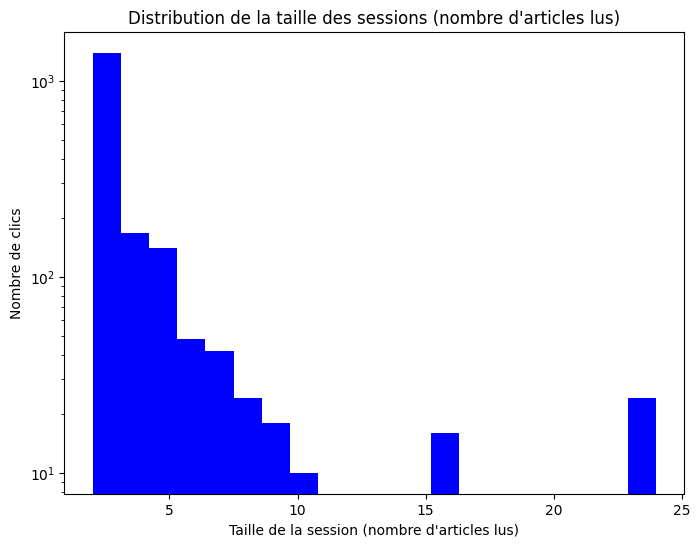

In [81]:
# Histogramme de session size avec échelle logarithmique sur l'axe y
fig = plt.figure(figsize=figsize)
plt.hist(clicks_sample['session_size'], bins=20, color='blue')
plt.xlabel("Taille de la session (nombre d'articles lus)")
plt.ylabel("Nombre de clics")
plt.title("Distribution de la taille des sessions (nombre d'articles lus)")

# Utiliser une échelle logarithmique sur l'axe y
plt.yscale('log')
# plt.xlim([0, 40])
#plt.ylim([0, 1.E6])

plt.show()

In [82]:
print(f"Date du premier article consulté : {clicks_sample['click_time'].min()}")
print(f"Date du dernier article consulté : {clicks_sample['click_time'].max()}")

Date du premier article consulté : 2017-10-01 03:00:00.026000
Date du dernier article consulté : 2017-10-03 02:35:54.157000


#### 2.2.2 Concaténation des fichiers click_hours

Concaténons l'ensemble des fichiers du dossier clicks afin d'obtenir l'historique complet des clics enregistrés :

In [83]:
def merge_csv_files(folder_path, merged_file_name):
    """
    Fusionne tous les fichiers CSV dans un dossier en un seul fichier CSV.

    Args:
        folder_path (str): Le chemin d'accès au dossier contenant les fichiers CSV.
        merged_file_name (str): Le nom du fichier fusionné.

    Returns:
        Merged dataframe
    """
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    merged_clicks = pd.DataFrame()
    
    for csv_file in csv_files:
        df = pd.read_csv(csv_file.replace("\\\\", "\\"))
        merged_clicks = pd.concat([merged_clicks, df], ignore_index=True)

    merged_clicks.to_csv(merged_file_name, index=False)

    return merged_clicks

In [84]:
# Upload or concatenated the history of the clicks
folder_path ='data\clicks\clicks'
merged_file_name = 'data\merged_clicks.csv'
if os.path.isfile(merged_file_name):
    merged_clicks = pd.read_csv(merged_file_name)
    print("Merged_clicks file already exists. Upload complete")
else:
    merged_clicks = merge_csv_files(folder_path, merged_file_name)

Merged_clicks file already exists. Upload complete


In [85]:
merged_clicks = merged_clicks.astype('int64')

Le dataset obtenu, **merged_clicks** contient l'historique de 2164021 clics que nous allons analyser de la même façon que l'échantillon précédent.

<u> Forme et propriétés du dataset </u> 

In [86]:
# Content and properties of the dataset
print("Forme du dataset : " + str(merged_clicks.shape))
print("-")
print("Features : " + str(merged_clicks.keys().tolist()))
print("-")
print("Types de fichiers : ")
merged_clicks.dtypes

Forme du dataset : (2988181, 12)
-
Features : ['user_id', 'session_id', 'session_start', 'session_size', 'click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']
-
Types de fichiers : 


user_id                int64
session_id             int64
session_start          int64
session_size           int64
click_article_id       int64
click_timestamp        int64
click_environment      int64
click_deviceGroup      int64
click_os               int64
click_country          int64
click_region           int64
click_referrer_type    int64
dtype: object

<u> Conversion des dates de clic et suppression des variables non pertinentes </u>

In [87]:
# Convert click_timestamp in dates
merged_clicks['click_time'] = pd.to_datetime(merged_clicks['click_timestamp'], unit='ms')#.dt.date

In [88]:
# Remove non relevant data
merged_clicks = merged_clicks.drop(
        columns=['session_start','session_id',
                 'click_environment','click_os','click_referrer_type',
                 'click_deviceGroup','click_region','click_country'])

<u> Analyse des données </u>

In [89]:
merged_clicks.head(5)

,user_id,session_size,click_article_id,click_timestamp,click_time
0,0,2,157541,1506826828020,2017-10-01 03:00:28.020
1,0,2,68866,1506826858020,2017-10-01 03:00:58.020
2,1,2,235840,1506827017951,2017-10-01 03:03:37.951
3,1,2,96663,1506827047951,2017-10-01 03:04:07.951
4,2,2,119592,1506827090575,2017-10-01 03:04:50.575


In [90]:
merged_clicks.drop(columns={'click_time'}).describe()

,user_id,session_size,click_article_id,click_timestamp
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06
mean,1.079478e+05,3.901885e+00,1.949226e+05,1.507474e+12
std,8.364836e+04,3.929941e+00,9.076842e+04,3.858510e+08
min,0.000000e+00,2.000000e+00,3.000000e+00,1.506827e+12
25%,4.034100e+04,2.000000e+00,1.242280e+05,1.507127e+12
50%,8.622900e+04,3.000000e+00,2.023810e+05,1.507495e+12
75%,1.632610e+05,4.000000e+00,2.770670e+05,1.507751e+12
max,3.228960e+05,1.240000e+02,3.640460e+05,1.510603e+12


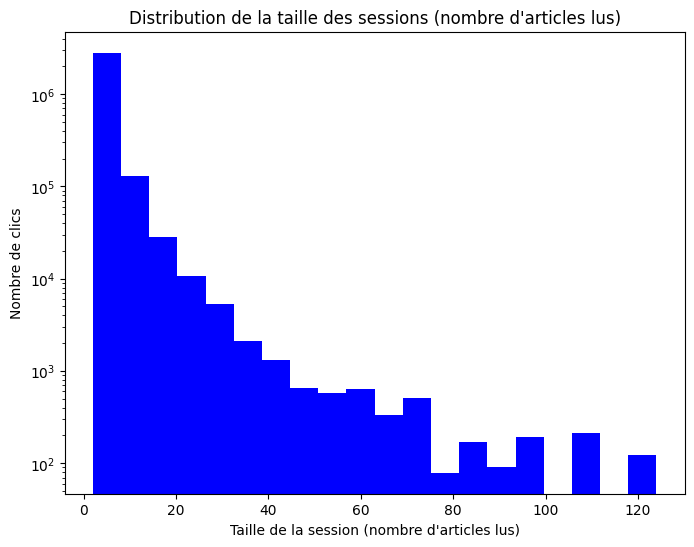

In [91]:
# Histogramme de session size avec échelle logarithmique sur l'axe y
fig = plt.figure(figsize=figsize)
plt.hist(merged_clicks['session_size'], bins=20, color='blue')
plt.xlabel("Taille de la session (nombre d'articles lus)")
plt.ylabel("Nombre de clics")
plt.title("Distribution de la taille des sessions (nombre d'articles lus)")

# Utiliser une échelle logarithmique sur l'axe y
plt.yscale('log')

# Définir les étiquettes et les emplacements de l'axe y
# plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])

# Limites des axes
# plt.xlim([0, 40])
# plt.ylim([0, 1.E6])

# Ajouter une grille
# plt.grid(True, which='both')

plt.show()
fig.savefig('data/figs/sessionsize.png', dpi=300, bbox_inches='tight')

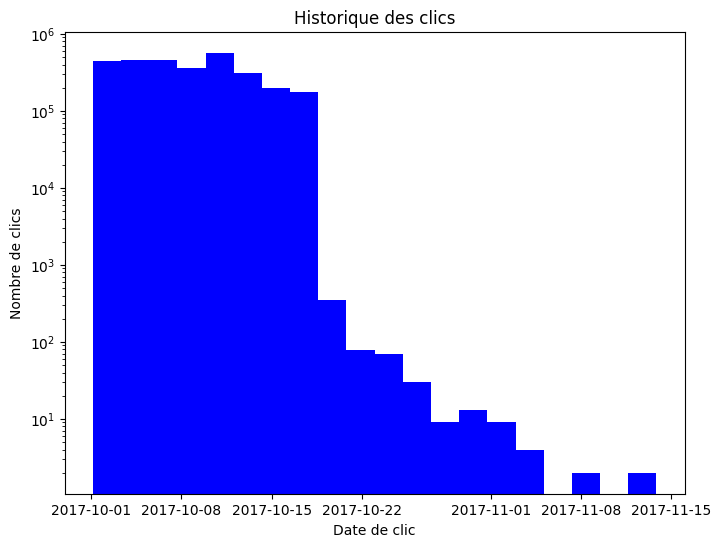

In [92]:
# Histogramme des dates de clic avec échelle logarithmique sur l'axe y
fig = plt.figure(figsize=figsize)
plt.hist(merged_clicks['click_time'], bins=20, color='blue')
plt.xlabel("Date de clic")
plt.ylabel("Nombre de clics")
plt.title("Historique des clics")

# Utiliser une échelle logarithmique sur l'axe y
plt.yscale('log')

# Définir les étiquettes et les emplacements de l'axe y
# plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])

# Limites des axes
# plt.xlim([0, 40])
# plt.ylim([0, 1.E6])

# Ajouter une grille
# plt.grid(True, which='both')

plt.show()
fig.savefig('data/figs/clics_history.png', dpi=300, bbox_inches='tight')

In [93]:
print(f"Date du premier article consulté : {merged_clicks['click_time'].min()}")
print(f"Date du dernier article consulté : {merged_clicks['click_time'].max()}")

Date du premier article consulté : 2017-10-01 03:00:00.026000
Date du dernier article consulté : 2017-11-13 20:04:14.886000


In [94]:
print(f"Nombre de clics : {len(merged_clicks)}")
print(f"Nombre d'utilisateurs uniques : {len(merged_clicks['user_id'].unique())}")
print(f"Nombre d'articles uniques : {len(merged_clicks['click_article_id'].unique())}")

Nombre de clics : 2988181
Nombre d'utilisateurs uniques : 322897
Nombre d'articles uniques : 46033


Ainsi, le dataset **clics** contient:
- 277379 utilisateurs uniques ayant sollicité 2164021 clics;
- les clics couvrent une période allant du 1er octobre au 13 novembre 2017;
- chaque utilisateur a cliqué sur un nombre d'articles compris entre 2 et 124

### 2.3 Matrice d'embedding 

Le fichier **articles_embeddings.pickle** contient une matrice d'embeddings d'articles, avec 364 047 vecteurs d'embeddings de dimension 250, représentant chacun un vecteur. 

In [95]:
import pickle

# Ouverture du fichier en mode lecture binaire
with open(r'data\articles_embeddings.pickle', 'rb') as f:
    # Chargement des données du fichier pickle
    articles_embeddings = pickle.load(f)

# Affichage des données chargées
print(articles_embeddings.shape)

(364047, 250)


##### Réduction de dimension par la méthode TSNE

La méthode t-SNE (t-distributed Stochastic Neighbor Embedding) est appliquée sur l'embedding d'articles afin de réduire ses dimensions et mieux comprendre visuellement sa structure.

Il a été envisagé de réaliser une ACP en prétraitement afin d'améliorer la qualité des projections de la t-SNE.

Les temps de calculs étant conséquents, l'utilisation de la t-SNE a été finalement effectuée sans ACP et uniquement sur les 5000 premiers articles.
Cela permet de montrer que les articles semblent classés par catégories, les 5000 premiers articles correspondant à une partie des 3 premières catégories.

    # Réduction avec méthode plus rapide pca

    from sklearn.decomposition import TruncatedSVD
    from sklearn.preprocessing import StandardScaler

    # Centrer et réduire la matrice d'embeddings
    scaler = StandardScaler()
    matrix_scaled = scaler.fit_transform(matrix)

    # Réaliser l'ACP
    n_components = 50 # nombre de composantes souhaité
    pca = TruncatedSVD(n_components=n_components, random_state=random_state)
    components = pca.fit_transform(matrix_scaled)


    # Réduction de dimension avec PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(articles_embeddings)

    # Réduction de dimension avec t-SNE
    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_result = tsne.fit_transform(pca_result)

    # Création du scatter plot
    fig = plt.figure(figsize=figsize)
    plt.scatter(tsne_result[:,0], tsne_result[:,1])
    plt.show()

    # Print top 5 categories and get associated indexes
    top_5_categories = articles_metadata["category_id"].value_counts()[:5].index.tolist()
    print(f"Top 5 des catégories d'articles : {top_5_categories}")

    indexes = articles_metadata.index[articles_metadata["category_id"].isin(top_5_categories)].tolist() 
    print(f"Nombre d'articles associés : {len(indexes)}")

    from sklearn.manifold import TSNE
    import random
    import seaborn as sns

    # sample_size = 5000
    # indexes = random.sample(range(len(articles_embeddings)), sample_size)
    indexes = range(len(articles_embeddings))# range(5000)

    # Instanciation de la méthode t-SNE pour 2 dimensions
    tsne = TSNE(n_components=2, random_state=random_state)

    tsne = TSNE(n_components=2) 
    X_tsne = tsne.fit_transform(articles_embeddings[indexes])

    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    print(f"Forme du TSNE : {df_tsne.shape}")

    df_tsne.head(3)

    # Visualisation graphique des données par la technique TSNE
    fig = plt.figure(figsize=figsize)

    df_tsne["category_id"] = articles_metadata["category_id"][indexes]
    sns.scatterplot(
        x="tsne1", y="tsne2",hue="category_id",
        palette=sns.color_palette('Set2',articles_metadata["category_id"][indexes].nunique()),
        data=df_tsne,s=50, alpha=0.6)#, legend=None)

    plt.title('TSNE', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') 

    plt.show()
    fig.savefig('data/figs/TSNE_partiel.png', dpi=300, bbox_inches='tight')

### 2.4 Elements supplémentaires d'analyse exploratoire 

La réalisation d'un système de recommandation suscite quelques questions qui peuvent être éclaircies par une analyse exporatoire :
- Quel est le nombre d'articles lus par utilisateur ? 
- Par combien d'utilisateurs chaque article est-il lu ?
- Comment classer les articles consultés par un utilisateur : récence de la consultation, nombre de clics, durée de consultation ? Une combinaison ?

In [96]:
clicks = merged_clicks#.drop(columns=['click_timestamp'])
clicks['click_time'] = pd.to_datetime(clicks['click_time'])
clicks.head(3)

,user_id,session_size,click_article_id,click_timestamp,click_time
0,0,2,157541,1506826828020,2017-10-01 03:00:28.020
1,0,2,68866,1506826858020,2017-10-01 03:00:58.020
2,1,2,235840,1506827017951,2017-10-01 03:03:37.951


##### Merge par utilisateur

Sur une duréee de 43 jours :
- chaque utilisateur a cliqué entre 2 et 1232 fois et en médiane 4 fois et consulté entre 2 et 124 articles par session, avec une moyenne de 3;
- chaque utilisateur a consulté chaque article entre 2 et 1048 articles avec une médiane de 4
- la plupart des utilisateurs ont été actifs sur les 15 premiers jours uniquement.

In [97]:
var = 'user_id'
# Group data
df_user = clicks.groupby(var).agg({
    'click_article_id':'count',
    'session_size':'max', # median
    'click_time':'last'})

# Rename 
df_user = df_user.rename(columns={'session_size':'largest_session_by_user',# average session size
                                  'click_time':'last_clic_by_user',
                                  'click_article_id':'total_clics_by_user'
                                           })
df_user['total_articles_by_user'] = clicks.groupby(var).agg({'click_article_id':'unique'})['click_article_id']
df_user['total_articles_by_user'] = df_user['total_articles_by_user'].apply(lambda x: len(x))

In [98]:
df_user.head(6)

,total_clics_by_user,largest_session_by_user,last_clic_by_user,total_articles_by_user
user_id,,,,
0,8,2,2017-10-09 01:54:46.617,8
1,12,2,2017-10-17 01:01:09.398,12
2,4,2,2017-10-17 01:15:09.725,4
3,17,4,2017-10-12 03:19:55.593,17
4,7,3,2017-10-10 03:15:20.003,7
5,87,10,2017-10-16 22:19:20.852,84


In [99]:
df_user.describe()

,total_clics_by_user,largest_session_by_user,total_articles_by_user
count,322897.000000,322897.000000,322897.000000
mean,9.254285,3.266156,9.138239
std,14.946358,2.147438,14.344677
min,2.000000,2.000000,2.000000
25%,2.000000,2.000000,2.000000
50%,4.000000,3.000000,4.000000
75%,10.000000,4.000000,10.000000
max,1232.000000,124.000000,1048.000000


In [100]:
# Compute median values
df_user['total_clics_by_user'].median()
df_user['largest_session_by_user'].median()

3.0

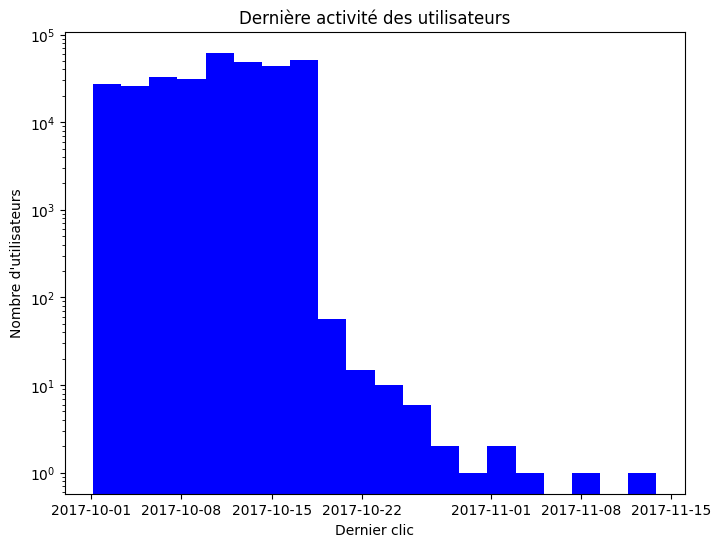

In [101]:
# Histogramme des derniers clics
fig = plt.figure(figsize=figsize)
plt.hist(df_user['last_clic_by_user'], bins=20, color='blue')
plt.xlabel("Dernier clic")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Dernière activité des utilisateurs")

# Utiliser une échelle logarithmique sur l'axe y
plt.yscale('log')

# Limites des axes
# plt.xlim([0, 40])
# plt.ylim([0, 1.E6])

plt.show()
fig.savefig('data/figs/df_user_history.png', dpi=300, bbox_inches='tight')

##### Merge par article

Sur une duréee de 43 jours, chaque article lu :
- a reçu entre 1 et 32713 clics, avec plus de 50% des articles n'ayant été consultés qu'une seule fois;
- a été consulté dans les 15 premiers jours uniquement.

Au total un peu moins de 13% des articles seulements ont été consultés.

In [102]:
var = 'click_article_id'
# Group data
df_article = clicks.groupby(var).agg({
    'user_id':'count',
    'click_time':'last'})

# Rename 
df_article = df_article.rename(columns={'click_time':'last_click_by_article',
                                        'user_id':'total_clics_by_article',
                                           })
df_article['total_readers'] = clicks.groupby(var).agg({'user_id':'unique'})['user_id']
df_article['total_readers'] = df_article['total_readers'].apply(lambda x: len(x))
#df_user['total_articles_by_user'] = clicks.groupby(var)['click_article_id'].nunique()

df_article.head(5)

,total_clics_by_article,last_click_by_article,total_readers
click_article_id,,,
3,1,2017-10-09 18:06:18.399,1
27,1,2017-10-04 19:21:06.293,1
69,1,2017-10-12 18:14:29.718,1
81,2,2017-10-02 19:56:55.111,2
84,1,2017-10-09 14:48:05.152,1


In [103]:
df_article.describe()

,total_clics_by_article,total_readers
count,46033.000000,46033.000000
mean,64.913888,64.099885
std,629.322888,617.366810
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,6.000000,6.000000
max,37213.000000,34145.000000


In [104]:
# Percentage of articles read 
np.round(100*df_article.shape[0]/articles_metadata.shape[0])

13.0

In [105]:
# Median values
df_article['total_readers'].median()
df_article['total_clics_by_article'].median()

1.0

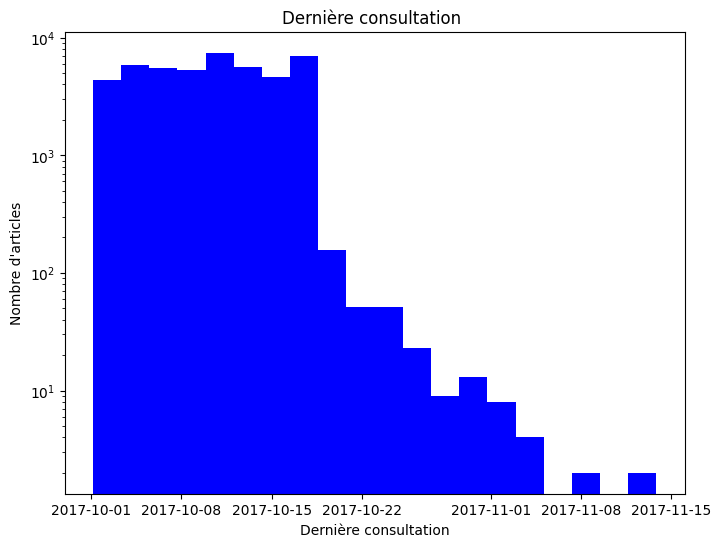

In [106]:
# Histogramme des derniers clics
fig = plt.figure(figsize=figsize)
plt.hist(df_article['last_click_by_article'], bins=20, color='blue')
plt.xlabel("Dernière consultation")
plt.ylabel("Nombre d'articles")
plt.title("Dernière consultation ")

# Utiliser une échelle logarithmique sur l'axe y
plt.yscale('log')

# Limites des axes
# plt.xlim([0, 40])
# plt.ylim([0, 1.E6])

plt.show()
fig.savefig('data/figs/df_article_history.png', dpi=300, bbox_inches='tight')

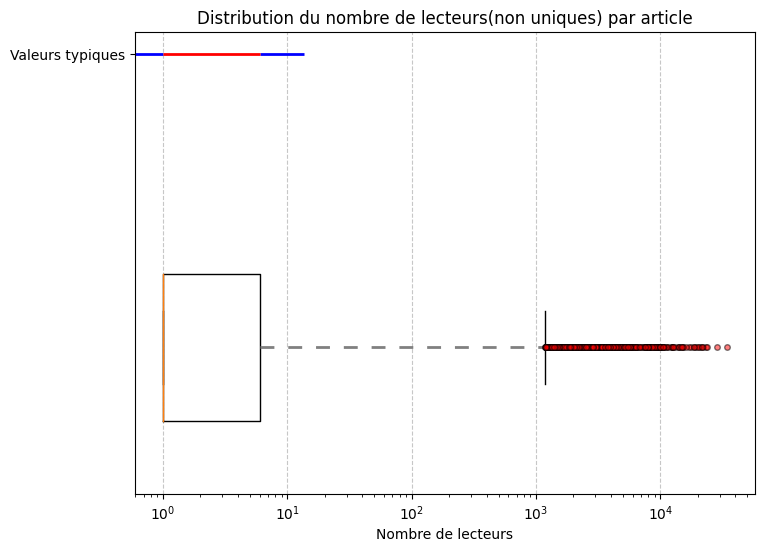

In [107]:
# Calcul des quartiles Q1, Q2 (médiane), Q3
q1, q2, q3 = df_article["total_readers"].quantile([0.25, 0.5, 0.75])

# Calcul des limites des whiskers
iqr = q3 - q1  # plage interquartile
whisker_min = q1 - 1.5 * iqr
whisker_max = q3 + 1.5 * iqr

# Création du boxplot avec les limites de whisker et les quartiles
fig = plt.figure(figsize=figsize)
bp = plt.boxplot(df_article["total_readers"], vert=False, widths=0.5, positions=[0], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)
plt.hlines(y=1, xmin=whisker_min, xmax=q1, colors='b', lw=2)
plt.hlines(y=1, xmin=q3, xmax=whisker_max, colors='b', lw=2)
plt.hlines(y=1, xmin=q1, xmax=q3, colors='r', lw=2)
plt.title("Distribution du nombre de lecteurs(non uniques) par article")
plt.xlabel("Nombre de lecteurs")
plt.yticks([1], ["Valeurs typiques"])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xscale('log')

plt.show()
fig.savefig('data/figs/readers_by_article.png', dpi=300, bbox_inches='tight')

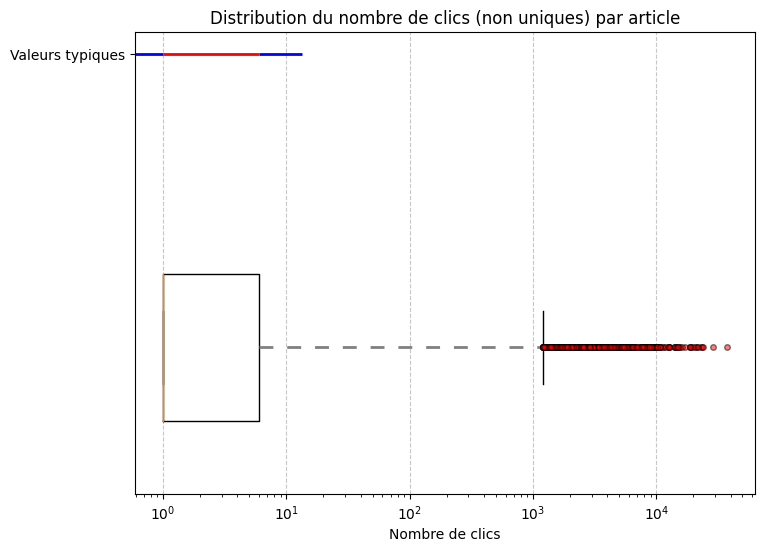

In [108]:
# Calcul des quartiles Q1, Q2 (médiane), Q3
q1, q2, q3 = df_article["total_clics_by_article"].quantile([0.25, 0.5, 0.75])

# Calcul des limites des whiskers
iqr = q3 - q1  # plage interquartile
whisker_min = q1 - 1.5 * iqr
whisker_max = q3 + 1.5 * iqr

# Création du boxplot avec les limites de whisker et les quartiles
fig = plt.figure(figsize=figsize)
bp = plt.boxplot(df_article['total_clics_by_article'], vert=False, widths=0.5, positions=[0], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)
plt.hlines(y=1, xmin=whisker_min, xmax=q1, colors='b', lw=2)
plt.hlines(y=1, xmin=q3, xmax=whisker_max, colors='b', lw=2)
plt.hlines(y=1, xmin=q1, xmax=q3, colors='r', lw=2)
plt.title("Distribution du nombre de clics (non uniques) par article")
plt.xlabel("Nombre de clics")
plt.yticks([1], ["Valeurs typiques"])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xscale('log')

plt.show()
fig.savefig('data/figs/clics_by_article.png', dpi=300, bbox_inches='tight')

##### Merge par couple (user-article)

Pour plus de 75% des articles lus l'utilisateur ne clique qu'une fois. Il clique au maximum 33 fois.

In [109]:
var = ['user_id','click_article_id']
# Group data
user_article = clicks.groupby(var,as_index=False).agg(
    user_id=('user_id','first'),
    click_article_id=('click_article_id','first'),
    clics_by_ua=('click_article_id','count'), # Nombre de clics par article (toutes sessions confondues)
    largest_session_by_ua=('session_size','max'),# plus large taille de session lorsque l'article est consulté
    last_clic_by_ua=('click_time','last')) # Dernier clic sur l'article

# user_article['']
# Note pour l'amélioration : il serait possible de rajouter plusieurs variables pour noter l'article par utilisateur
# - Récence de dernière lecture de l'article : à partir de la dernière date de clic enregistrée pour l'article
# - Nombre de sessions ouvertes avec l'article : il faudrait récupérer l'id de session (différent du user_id)
# - Durée moyenne de session avec l'article

# Preview dataframe
user_article.head(15)

,user_id,click_article_id,clics_by_ua,largest_session_by_ua,last_clic_by_ua
0,0,68866,1,2,2017-10-01 03:00:58.020
1,0,87205,1,2,2017-10-09 01:54:46.617
2,0,87224,1,2,2017-10-09 01:54:16.617
3,0,96755,1,2,2017-10-07 01:33:53.155
4,0,157541,1,2,2017-10-01 03:00:28.020
5,0,160158,1,2,2017-10-07 14:54:50.915
6,0,233470,1,2,2017-10-07 14:55:20.915
7,0,313996,1,2,2017-10-07 01:34:23.155
8,1,36162,1,2,2017-10-17 01:00:39.398
9,1,59758,1,2,2017-10-01 17:36:36.845


In [110]:
df_user.describe()

,total_clics_by_user,largest_session_by_user,total_articles_by_user
count,322897.000000,322897.000000,322897.000000
mean,9.254285,3.266156,9.138239
std,14.946358,2.147438,14.344677
min,2.000000,2.000000,2.000000
25%,2.000000,2.000000,2.000000
50%,4.000000,3.000000,4.000000
75%,10.000000,4.000000,10.000000
max,1232.000000,124.000000,1048.000000


In [111]:
df_article.describe()

,total_clics_by_article,total_readers
count,46033.000000,46033.000000
mean,64.913888,64.099885
std,629.322888,617.366810
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,6.000000,6.000000
max,37213.000000,34145.000000


In [112]:
user_article = user_article.merge(df_user, on = 'user_id', how = 'left')

In [113]:
user_article = user_article.merge(df_article, on = 'click_article_id', how = 'left')

In [114]:
user_article.describe()

,user_id,click_article_id,clics_by_ua,largest_session_by_ua,total_clics_by_user,largest_session_by_user,total_articles_by_user,total_clics_by_article,total_readers
count,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06
mean,1.083921e+05,1.950297e+05,1.012699e+00,3.907438e+00,3.264312e+01,5.812462e+00,3.165561e+01,6.124626e+03,6.010031e+03
std,8.372895e+04,9.083343e+04,1.344699e-01,3.934087e+00,5.677744e+01,5.800024e+00,5.203223e+01,7.382307e+03,7.134619e+03
min,0.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
25%,4.072000e+04,1.242280e+05,1.000000e+00,2.000000e+00,8.000000e+00,3.000000e+00,8.000000e+00,6.620000e+02,6.540000e+02
50%,8.683000e+04,2.023880e+05,1.000000e+00,3.000000e+00,1.700000e+01,4.000000e+00,1.700000e+01,3.097000e+03,3.072000e+03
75%,1.639750e+05,2.770680e+05,1.000000e+00,4.000000e+00,3.800000e+01,7.000000e+00,3.700000e+01,9.203000e+03,9.083000e+03
max,3.228960e+05,3.640460e+05,3.300000e+01,1.240000e+02,1.232000e+03,1.240000e+02,1.048000e+03,3.721300e+04,3.414500e+04


In [115]:
# Compute median
user_article['clics_by_ua'].median()

1.0

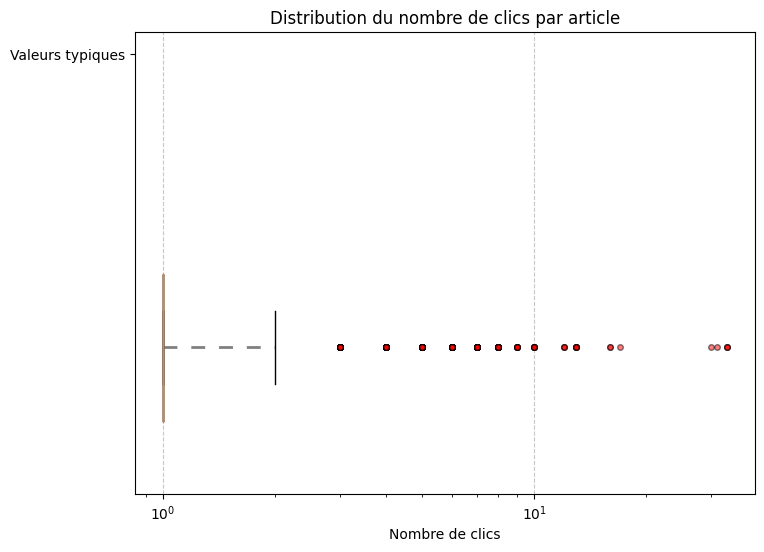

In [116]:
# Calcul des quartiles Q1, Q2 (médiane), Q3
q1, q2, q3 = user_article['clics_by_ua'].quantile([0.25, 0.5, 0.75])

# Calcul des limites des whiskers
iqr = q3 - q1  # plage interquartile
whisker_min = q1 - 1.5 * iqr
whisker_max = q3 + 1.5 * iqr

# Création du boxplot avec les limites de whisker et les quartiles
fig = plt.figure(figsize=figsize)
bp = plt.boxplot(user_article['clics_by_ua'], vert=False, widths=0.5, positions=[0], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)
plt.hlines(y=1, xmin=whisker_min, xmax=q1, colors='b', lw=2)
plt.hlines(y=1, xmin=q3, xmax=whisker_max, colors='b', lw=2)
plt.hlines(y=1, xmin=q1, xmax=q3, colors='r', lw=2)
plt.title("Distribution du nombre de clics par article")
plt.xlabel("Nombre de clics")
plt.yticks([1], ["Valeurs typiques"])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xscale('log')

plt.show()
fig.savefig('data/figs/unique_clicks_by_article.png', dpi=300, bbox_inches='tight')

## 3. Modélisation du système de recommandation

Deux approches sont considérées :
- **content-based** : Cette méthode utilise seulement les informations sur les articles que les utilisateurs ont consommés pour recommander des articles similaires. Les algorithmes cherchent à recommander des articles qui correspondent aux préférences de l'utilisateur en se basant sur ses évaluations précédentes.

- **collaboratif-filtering**: Cette méthode utilise la collaboration de nombreuses préférences d'utilisateurs pour faire des prédictions automatiques sur les intérêts d'un utilisateur. Elle est basée sur l'hypothèse que si deux personnes ont des opinions similaires sur plusieurs éléments, elles auront probablement des opinions similaires sur d'autres éléments.

### 3.1 Approche content-based

#### Démarche générale

La démarche générale de recommandation d'articles via l'approche content-based comporte plusieurs étapes :
- Choix de l'utilisateur : sélectionné au hasard ou par user_id;
- Choix de l'article de référence pour la recommandation : 
    - Dernier article consulté (ancienneté);
    - Article le plus consulté (nombre de clics); si plusieurs, le plus récent; 
- Recommandations avec l'approche content-based, basées sur le calcul du coefficient de cosin similarité avec l'article de référence : les articles les plus proches de ce dernier sont ceux dont le coefficient est le plus proche de 1. Les 5 premiers articles sont ainsi séléctionnés en recommandation.

#### Recommandations

In [117]:
# Content-based recommendation for a chosen user
@interact(
    idx=widgets.IntSlider(min=0, max=len(clicks['user_id'].unique()),
                          step=1, value=57288,
                          description="User Id :"))
def show_data(idx):

    # 0. Get random user_id

    # rng = np.random.RandomState(18)
    # user_id = rng.choice(clicks['user_id'].unique())
    # user_id = 5880#
    #user_id = random.choice(clicks['user_id'].unique())
    user_id = idx
    print('SELECTED USER')
    print(f"User id : {user_id}")

    # 1. Get reference article based on metier preference

    print('--')    
    print('REFERENCE ARTICLE')
    #article_id = select_article(last', clicks, user_id)
    article_id = select_article('most clicked',clicks,user_id)
    display(articles_metadata[articles_metadata['article_id']==article_id].drop(columns=['created_at_ts','publisher_id']))

    ## 2. Compute cosin similarity of this article with those of the embedding matrix  & get recos

    df_articles_embeddings = pd.DataFrame(articles_embeddings, columns=["embedding_" + str(i) for i in range(articles_embeddings.shape[1])])
    recos = get_cosinsimilarity(df_articles_embeddings,article_id)
    print('--')    
    print(f"RECOMMENDED ARTICLES : {recos}")

    display(articles_metadata.loc[recos].drop(columns=['created_at_ts','publisher_id']))


interactive(children=(IntSlider(value=57288, description='User Id :', max=322897), Output()), _dom_classes=('w…

#### 3.2 Approche collaborative featuring

#### Démarche générale

La filtrage collaboratif est une famille d'algorithmes permettant d'identifier des utilisateurs ou des éléments similaires et de calculer une note basée sur celles des utilisateurs similaires.

La première étape pour notre problème de recommandation d'articles est donc d'assigner une note, par lecteur, à chacun des articles consultés, à partir des données disponibles.

Un algorithme de filtrage collaboratif sera ensuite utilisé pour assigner, pour chaque lecteur, une note à chacun des articles qu'il n'a pas consultés mais qui l'ont été par d'autres utilisateurs.

L'approche par filtrage collaboratif dit user-based consiste à apprendre du comportement passé de lecteur ainsi que de celui des lecteurs identifiés comme similaires pour prédire les préférences de lecture.

La recommandation d'articles en utilsant cette approche consiste en les étapes suivantes :
- Choix du lecteur : par hasard ou séléctionné par id;
- Identification des lecteurs aux goûts similaires par l'approche filtrage collaboratif. Un calcul de similarité est effectué entre utilisateurs, en se basant sur les articles consultés en commun. Différentes métriques peuvent être utilisées à cet effet;
- Affectation d'une note pour les articles encore non consultés, pondérée par la similarité avec les autres utilisateurs; cette affectation est obtenue grâce à l'entraînement d'un algorithme de factorisation matricielle qui prédit des notes pour chaque couple article-lecteur;  
- Recommandations pour le lecteur choisi des 5 articles non lus ayant obtenu les meilleures notes.

La librairie Surprise est utilisée pour mettre en place et entraîner l'algorithme de filtrage collaboratif. L'algorithme utilisé est la technique de factorisation matricielle SVD. Elle permet de découvrir les caractéristiques latentes sous-jacentes aux interactions entre les utilisateurs et les éléments et minimise les risques de surapprentissage. 

L'évaluation du modèle est obtenue en analysant l'erreur RMSE (root mean square erreur) entre les notes réelles et celles prédites. Le modèle peut être optimisé par un choix judicieux d'hyperparamètres permettant de minimiser cette erreur.


#### Calcul de note 

Considérons les notes suivantes pour le couple utilisateur-article :
- **Nombre de clics** 
- **Nombre de clics / Nombre de clics total effectués par l'utilisateur**. Cette note permet d'estimer l'importance relative de l'article pour l'utilisateur par rapport au nombre de clics effectués sur l'ensemble des autres articles consultés.
- **Nombre de clics / Taille de session maximale lorsque l'article est consulté**. Cette dernière note permet d'indiquer l'intérêt de l'utilisateur en fonction du nombre de clics sur l'article ainsi que relativement au temps passé dessus. Si la taille de session maximale est petite, cela signifie que l'utilisateur a probablement passé un temps plus significatif sur l'article que si la taille de session était grande et qu'il avait donc partagé son temps sur plusieurs autres articles.

In [118]:
# Preview of all variables that could be used to define a rate
user_article.drop(columns=['user_id','click_article_id','last_clic_by_ua','last_click_by_article']).head(5)

,clics_by_ua,largest_session_by_ua,total_clics_by_user,largest_session_by_user,last_clic_by_user,total_articles_by_user,total_clics_by_article,total_readers
0,1,2,8,2,2017-10-09 01:54:46.617,8,1500,1491
1,1,2,8,2,2017-10-09 01:54:46.617,8,1344,1334
2,1,2,8,2,2017-10-09 01:54:46.617,8,4885,4812
3,1,2,8,2,2017-10-09 01:54:46.617,8,5967,5930
4,1,2,8,2,2017-10-09 01:54:46.617,8,368,364


In [119]:
# Define a rate for each user-article pair
rates = user_article[['user_id','click_article_id','clics_by_ua']].copy()
rates['user_clic_ratio'] = user_article['clics_by_ua'] / user_article['total_clics_by_user'] # click ratio de l'utilsateur sur l'article
rates['clics_per_session'] = user_article['clics_by_ua'] / user_article['largest_session_by_ua'] # click
rates.head(10)

,user_id,click_article_id,clics_by_ua,user_clic_ratio,clics_per_session
0,0,68866,1,0.125000,0.5
1,0,87205,1,0.125000,0.5
2,0,87224,1,0.125000,0.5
3,0,96755,1,0.125000,0.5
4,0,157541,1,0.125000,0.5
5,0,160158,1,0.125000,0.5
6,0,233470,1,0.125000,0.5
7,0,313996,1,0.125000,0.5
8,1,36162,1,0.083333,0.5
9,1,59758,1,0.083333,0.5


##### Visualisation des notes

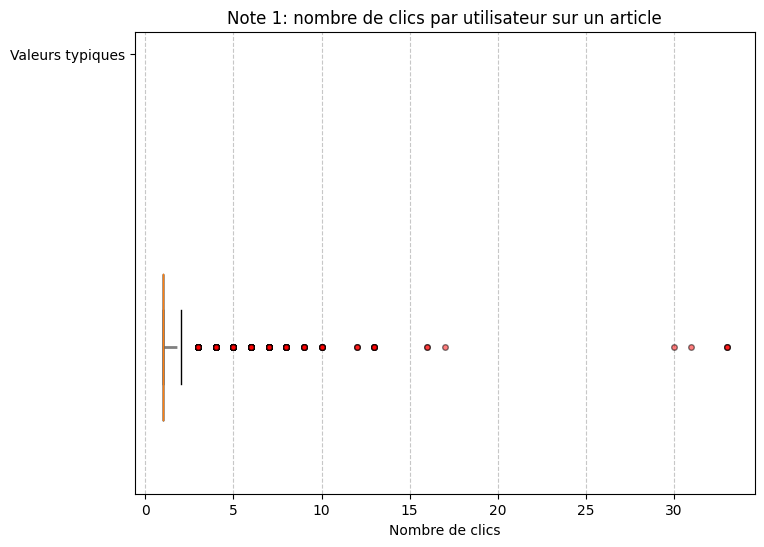

In [120]:
visualize_histogram(rates["clics_by_ua"], "Note 1: nombre de clics par utilisateur sur un article", "Nombre de clics", 'data/figs/rate_1.png')

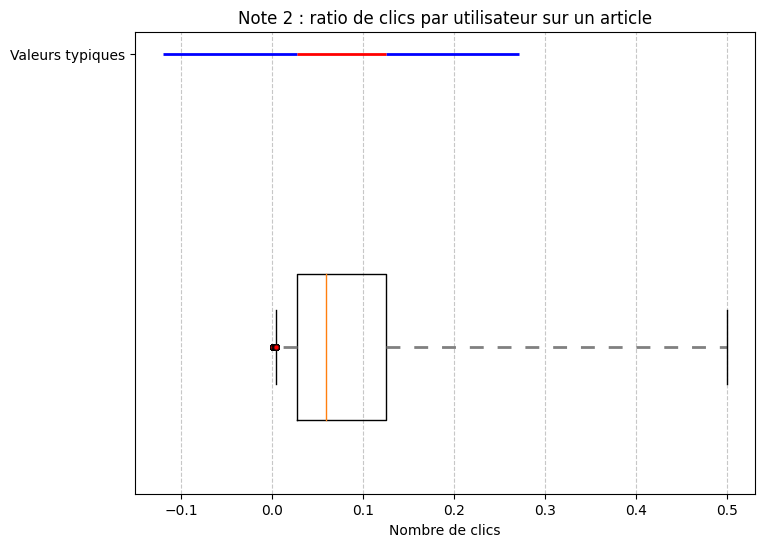

In [121]:
visualize_histogram(rates["user_clic_ratio"], "Note 2 : ratio de clics par utilisateur sur un article", "Nombre de clics", 'data/figs/rate_2.png')

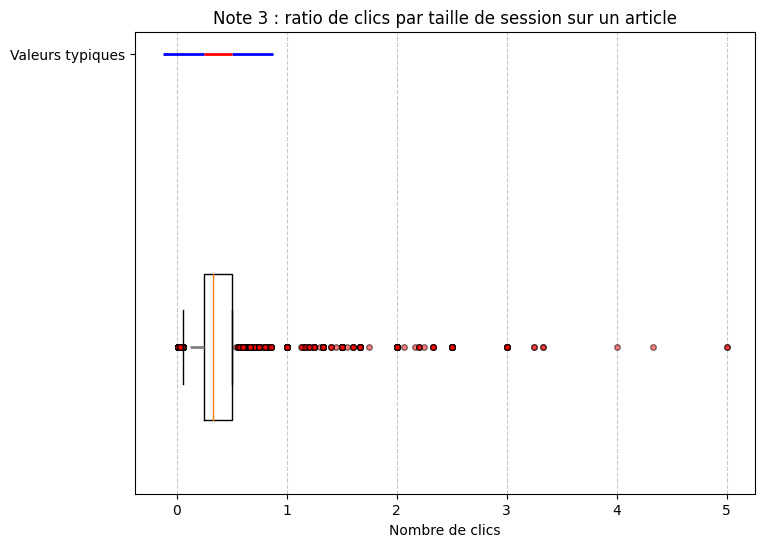

In [122]:
visualize_histogram( rates["clics_per_session"], "Note 3 : ratio de clics par taille de session sur un article", "Nombre de clics", 'data/figs/rate_3.png')

Le **ratio de clics par session** sur chaque article semble être la meilleure option car elle possède la plus grande variabilité de valeurs.
Il sera intéressant de tester également le nombre de **ratio de clics par utilisateur***.


#### Algorithme de filtrage collaboratif SVD

L'algorthime SVD  est utilisé pour le réaliser le filtrage collaboratif basé sur les comportements d'utilisateurs (user-based collaborative filtering). RAJOUTER DESCRIPTION SUR FACTO MATRICIELLE
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD 

- Les données reliant articles et utilisateurs sont fournies de façon **explicite** puisqu'il s'agit d'une note calculée;
- Les notes "clics_by_session" sont comprises entre 0 et 5. Le paramètre rating_scale de la classe Reader, utilisé dans la librairie surprise, est modifié de façon à spécifier la bonne échelle de notation des données dans la librairie;
- Les hyperparamètres **n_factors**, **n_epochs**, **lr_all** et **reg_all**  de l'algorithme SVD sont optimisés à l'aide d'une fonction gridsearch;
    -  n_factors correspond au nombre de facteurs latents (ou de dimensions cachées) utilisé pour décrire les utilisateurs et les articles dans le modèle;
    - n_epochs est le nombre d'itérations;
    - lr_all est le taux d'apprentissage pour tous les paramètres, qui est un paramètre qui décide de la quantité de réglage des paramètres à chaque itération;
    - reg_all est le terme de régularisation pour tous les paramètres, qui est un terme de pénalité ajouté pour éviter le surapprentissage. 
- Les métriques RMSE et MAE sont utilisés pour l'évaluation. Les valeurs des notes prédites et réelles sont également visualisées pour quelques paires article-utilisateur choisies.


<u> Approche item-based vs user-based</u>

EXPLIQUER ITEM VS USER 
Si le nombre d'utilisateurs est plus large que le nombre d'articles, l'approche item-based est plus rapide et plus stable. La note moyenne reçue par un article ne change pas aussi rapidement que la note moyenne donnée par un utilisateur à différents articles. Cette approche fonctionne également mieux lorsque la matrice de notes est clairsemée.

Dans notre cas le nombre d'utilisateurs est légèrement inférieur au nombre d'articles (lus), le taux de remplissage de la matrice est de 0.02 %.

La matrice étant quasiment vide, une technique de réduction de dimension comme une méthode de factorisation est utilisée pour améliorer les performances de l'algorithme de filtrage.


In [123]:
print(f"Nombre d'utilisateurs : {user_article['user_id'].nunique()}")
print(f"Nombre d'articles lus : {user_article['click_article_id'].nunique()}")
print(f"Nombre total d'articles : {articles_metadata['article_id'].nunique()}")
print(f"Nombre de paires utilisateur-article : {user_article.shape[0]}")
print(f"Taux de remplissage de la matrice user-article : {np.round(100*user_article.shape[0]/(user_article['user_id'].nunique()*user_article['click_article_id'].nunique()),2)} %")
print(f"Taille de la matrice : {np.round((1E-9)*(user_article['user_id'].nunique()*articles_metadata['article_id'].nunique()),2)} milliards")

Nombre d'utilisateurs : 322897
Nombre d'articles lus : 46033
Nombre total d'articles : 364047
Nombre de paires utilisateur-article : 2950710
Taux de remplissage de la matrice user-article : 0.02 %
Taille de la matrice : 117.55 milliards


In [125]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate


# Data prepation for surprise
userId = 'user_id'
articleId = 'click_article_id'
# rating = 'user_clic_ratio' # Note 2
rating = 'clics_per_session' # Note 3
pred_rating = 'pred_' + rating 
data = rates

# Format data for surprise
# reader = Reader(rating_scale=(0,0.5)) # Note 2
reader = Reader(rating_scale=(0,5)) # Note 3

data = Dataset.load_from_df(data[[userId, articleId, rating]], reader)

# Choose training type
training_type = 'simple' 
#training_type = 'grid_search'


if training_type == 'simple':
    # Split data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.25, random_state=random_state)
    # trainset = data.build_full_trainset() # to use all data for training
     
    # Train the model
    SVD_model = SVD(n_factors=100, n_epochs=20, random_state=random_state)  
    cross_validate(SVD_model, data, measures=["RMSE", "MAE"], cv=5, verbose=True) # Run 5-fold cross-validation and print results
    # SVD_model.fit(trainset, verbose=True, n_jobs=-1)

    # Predict accuracy
    predictions = SVD_model.test(testset)  
    print('Basic model accuracy :')
    print(f"(rmse) : {accuracy.rmse(predictions)}")
    print(f"(mae): {accuracy.mae(predictions)}")
    print(f"(fcp): {accuracy.fcp(predictions)}")
    print(f"(mse): {accuracy.mae(predictions)}")


elif training_type == "grid_search":
    # grid search parameters
    param_grid = {'n_factors': [50, 100, 150], 'n_epochs': [10, 20, 50], 'lr_all':[0.002, 0.005, 0.007], 'reg_all':[0.01, 0.02, 0.04]} 

    # Train the model
    gs = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=3) # add  to use all cores
    gs.fit(data, verbose=True, n_jobs=-1)

    # best RMSE score and parameters
    print('(Gridsearch-)Optimized model accuracy :')
    print(f"Best RMSE score : {gs.best_score['rmse']}")
    print(f"Best MAE score : {gs.best_score['mae']}")
    print(f"Best hyperparameters (rmse): {gs.best_params['rmse']}")
    print(f"Best hyperparameters (mae) : {gs.best_params['mae']}")
    print(f"Best model (rmse) : {gs.best_estimator['rmse']}")
    print(f"Best model (mae) : {gs.best_estimator['mae']}")

    # Train the best model
    SVD_model = gs.best_estimator['rmse']
    trainset = data.build_full_trainset() # to use all data for training
    SVD_model.fit(trainset, verbose=True, n_jobs=-1)

# Get predicted rates for each user-article pair already rated
rates[pred_rating] = rates.apply(lambda x: SVD_model.predict(x['user_id'], x['click_article_id']).est, axis=1) 

ModuleNotFoundError: No module named 'surprise'

##### Métrique d'évaluation

Plusieurs métriques sont utilisées pour évaluer les prédictions. Ces évaluations sont réalisées sur un jeu de test contenant donc des paires article-utilisateur avec déjà une note réelle.
- Erreur RMSE (Root Mean Square Error): moyenne quadratique des erreurs des prediction
- Mean Absolute Error (MAE) : moyenne des valeurs absolues des erreurs

##### Visualisation des prédictions

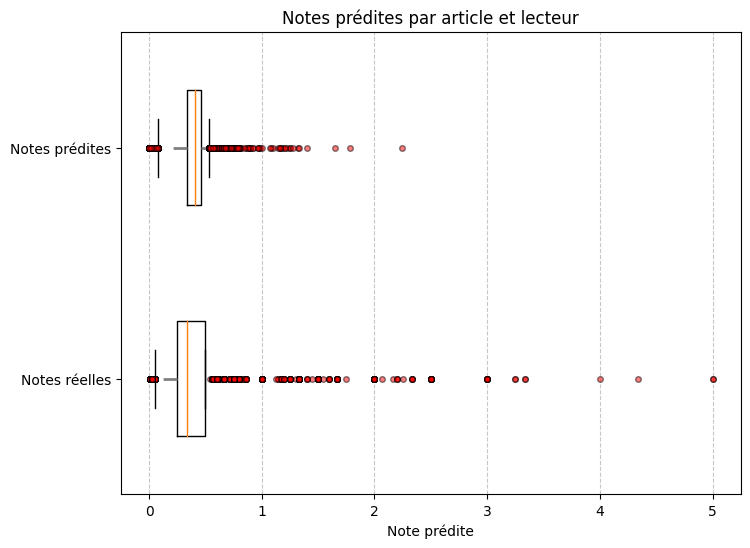

In [ ]:
# Plot Boxplots for predicted rates and real rates
fig = plt.figure(figsize=figsize)

# Real rates
bp = plt.boxplot(rates[rating], vert=False, widths=0.5, positions=[0], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

# Predicted rates
bp = plt.boxplot(rates[pred_rating], vert=False, widths=0.5, positions=[1], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

# Predicted rates fullset
# bp = plt.boxplot(rates[pred_rating +'_fullset'], vert=False, widths=0.5, positions=[2], whis=[1,99])
# plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
# plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

plt.yticks([0, 1], ["Notes réelles", "Notes prédites"])
#plt.yticks([0, 1, 2], ["Notes réelles", "Notes prédites - Modèle de base", "Notes prédites - Modèle optimisé"])


plt.title("Notes prédites par article et lecteur") 
plt.xlabel("Note prédite")

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()
fig.savefig('data/figs/real_vs_pred_rates.png', dpi=300, bbox_inches='tight')

In [ ]:
# Side by side comparison of real rates and predicted rates by user  
@interact(
    idx=widgets.IntSlider(min=min(rates['user_id'].unique()), max=max(rates['user_id'].unique()),
                          step=1, value=57288,#149963,
                          description="User Id :"))   


def show_side_by_side(idx):
    width = 0.35  # width of the bars
    n_bars = len(rates[rates['user_id']==idx])  # number of bars to plot
    ind = np.arange(n_bars)  # indices of the bars
    
    fig, ax = plt.subplots()

    # bars with real rates
    rects1 = ax.bar(ind, rates[rates['user_id']==idx][rating], width, color='r')

    # bars with predicted rates
    rects2 = ax.bar(ind + width, rates[rates['user_id']==idx][pred_rating], width, color='y')

    # bars with predicted rates fullset
    # rects3 = ax.bar(ind + width*2, rates[rates['user_id']==idx][pred_rating +'_fullset'], width, color='g')

    # legend and labels
    ax.set_xlabel('Observations')
    ax.set_ylabel('Valeurs')
    ax.legend((rects1[0], rects2[0]), ('Réelles', 'Prédites'))# , 'Prédites fullset')) #, rects3[0],
    ax.set_title('Comparaison des notes réelles et prédites pour les articles lus par un utilisateur')

    plt.show()


interactive(children=(IntSlider(value=57288, description='User Id :', max=322896), Output()), _dom_classes=('w…

In [ ]:
# Side by side comparison of real rates and predicted rates for a chosen number of samples
@interact(n_bars=widgets.IntSlider(min=0, max=100,
                          step=1, value=10,
                          description="Nombre d'échantillons :"))   
def show_side_by_side(n_bars):
    width = 0.35  # width of the bars
    
    ind = np.arange(len(rates[rating]))  # indices of the bars
    selected_bars = np.random.choice(ind, n_bars)
    
    fig, ax = plt.subplots()

    # bars with real rates
    rects1 = ax.bar(np.arange(n_bars), rates[rating][selected_bars], width, color='r')

    # bars with predicted rates
    rects2 = ax.bar(np.arange(n_bars) + width, rates[pred_rating][selected_bars], width, color='y')

    # legend and labels
    ax.set_xlabel('Observations')
    ax.set_ylabel('Valeurs')
    ax.legend((rects1[0], rects2[0]), ('Réelles', 'Prédites'))
    ax.set_title(f"Comparaison des notes réelles et prédites pour un échantillon de {n_bars} paires article/lecteur")

    plt.show()


interactive(children=(IntSlider(value=10, description="Nombre d'échantillons :"), Output()), _dom_classes=('wi…

##### Recommandations

In [ ]:
def get_best_rated_reco(user_id, articles_metadata, SVD_model):
    # Get all articles of the articles_metadata base (read and unread)
    recos = articles_metadata.drop(columns='created_at_ts').copy()

    # Rate for a user_id all the articles from the articles_metadata base
    recos['predicted_rate'] = recos['article_id'].apply(lambda x: SVD_model.predict(user_id, x).est)
    
    # Sort the articles by predicted rate
    recos = recos.sort_values(by='predicted_rate', ascending=False)

    # Remove the articles already read by the user
    recos = recos[~recos['article_id'].isin(rates[rates['user_id']==user_id]['click_article_id'].values)]

    # Get the top 5 articles
    top_recos = recos['article_id'][:5].values
    
    return top_recos, recos

In [ ]:
# Recommendation tool for collaborative filtering
@interact(
    idx=widgets.IntSlider(min=0, max=len(clicks['user_id'].unique()),
                          step=1, value=57288,
                          description="User Id :"))   
def show_data(idx):

    # 0. Get random user_id
    user_id = idx
    print('SELECTED USER : READ ARTICLES')
    print(f"User id : {user_id}")
    display(articles_metadata[articles_metadata['article_id'].isin(
        user_article[user_article['user_id']==idx]['click_article_id'].values)].drop(columns=['created_at_ts','publisher_id']))

    # 1. Predit rates for all the articles for this user_id and get the top 5 most rated articles
    top_recos, recos = get_best_rated_reco(user_id, articles_metadata, SVD_model)
    print('--')    
    print(f"RECOMMENDED ARTICLES : {top_recos}")
    display(recos[recos['article_id'].isin(top_recos)].drop(columns=['predicted_rate','publisher_id']))

interactive(children=(IntSlider(value=57288, description='User Id :', max=322897), Output()), _dom_classes=('w…

##### Sauvegarde du modèle final

In [ ]:
#### Sauvegarde du modèle

with open('model.pkl', 'wb') as f:
    pickle.dump(SVD_model, f)


## Synthèse des modèles de recommandation


### 4. Application Serverless

Le principe du Serverless est de pouvoir concevoir des applications sans avoir à penser à la gestion parfois fastidieuse des servers physiques, notamment:
- la configuration du framework Web
- le routage et la définition des requêtes

Le service le plus associé à la fonction Serverless est le service **Azure FaaS dit Azure Fonctions** (Function as a Service) :
- son fonctionnement se veut aussi simple qu'un fichier avec une seule méthode, la fonction Azure;
- cette méthode est appelée avec des déclencheurs ("trigger").

Il existe trois principes de Serverless :
- Pay as you go
- Event driven 
- Stateless : pour les fonctions de courte durée (5-10 min)

Le serverless est paticulièrement pratique pour les processus où la demande est faible ou chaotique, ainsi que pour ceux déclenché par des évènements  
